# I. Modis and Era5

## 1. DownLoad From Era5

In [17]:
import cdsapi
import xarray as xr
import pandas as pd

In [ ]:
c = cdsapi.Client()

dataset = 'reanalysis-era5-single-levels'

# nhiều năm
for year in range(2000, 2026):
    request = {
        'product_type': 'reanalysis',
        'variable': [
            '2m_temperature', 
            '2m_dewpoint_temperature',
            '10m_u_component_of_wind',
            '10m_v_component_of_wind',
            'total_precipitation',
        ],
        'date': f'{year}-01-01/{year}-12-31',
        'area': [23.5, 102, 8.5, 110],
        'format': 'netcdf', 
    }
    target = f'download_{year}.zip'
    print(f'Downloading {year}...')
    c.retrieve(dataset, request, target)
    print(f'Download for {year} completed.')

In [ ]:
# mở file instant
ds_instant = xr.open_dataset("download_2025/data_stream-oper_stepType-instant.nc", engine='netcdf4')
# mở file accum
ds_accum = xr.open_dataset("download_2025/data_stream-oper_stepType-accum.nc", engine='netcdf4')
# gộp 2 dataset
ds = xr.merge([ds_instant, ds_accum])
# chuyển sang dataframe
df = ds.to_dataframe().reset_index()

# lưu csv
df.to_csv("era5_2025.csv", index=False)
df = pd.read_csv('era5_2025.csv')
df.info()

# II. Clean Data

In [22]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date

In [23]:
df = pd.read_csv("data/data/clean/clean_2000_2024_timelines.csv")

### Ý nghĩa từng Features
- Temperature: Nhiệt độ môi trường đo theo độ C
- RH: Độ ẩm tương đối của không khí (%)
- Ws: Tố độ gió (km/h)
- Rain: Lượng mưa (mm)
- FFMC: Độ ẩm của lớp nhiên liệu mịn (thấp -> khó cháy | cao dễ bắt lửa)
- DMC: Độ ẩm lớp thảm mục dưới tầng lá. (tốc độ cháy ngầm)
- DC: Chỉ số hạn hán của lớp đất hữu cơ sâu (mức độ khô hạn dài hạn)
- ISI: Mức độ lan truyền của đám cháy ban đầu
- BUI: Mức tích lũy nhiên liệu cháy
- FWI: Nguy cơ cháy rừng tổng hợp


In [3]:
df.head()

,date,lat_grid,lon_grid,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,2000-01-01,8.5,102.0,26.52236,80.067211,15.839046,0.095367,84.371102,6.677832,19.478025,4.296570,7.191684,3.865526,not fire
1,2000-01-02,8.5,102.0,26.54970,82.890161,24.950707,0.027180,83.596241,7.260243,23.960971,6.133248,8.261978,5.994609,not fire
2,2000-01-03,8.5,102.0,26.33853,83.581047,21.598496,0.054359,83.323134,7.814869,28.405906,4.998554,9.260500,5.199164,not fire
3,2000-01-04,8.5,102.0,26.76846,81.695429,19.669963,0.064850,83.370287,8.442878,32.928229,4.563532,10.289880,5.021585,not fire
4,2000-01-05,8.5,102.0,26.54824,82.055978,22.993199,0.183105,83.417455,9.053652,37.410912,5.428682,11.281710,6.256100,not fire


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18382716 entries, 0 to 18382715
Data columns (total 14 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   lat_grid     float64
 2   lon_grid     float64
 3   Temperature  float64
 4   RH           float64
 5   Ws           float64
 6   Rain         float64
 7   FFMC         float64
 8   DMC          float64
 9   DC           float64
 10  ISI          float64
 11  BUI          float64
 12  FWI          float64
 13  Classes      object 
dtypes: float64(12), object(2)
memory usage: 1.9+ GB


In [5]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")

In [6]:
rows,cols=df.shape
print(f'There are {rows:,} Rows and {cols} Columns')

There are 18,382,716 Rows and 14 Columns


## 1. Data Visualization

In [7]:
not_fire = df[df['Classes'] == 'not fire'].shape[0]
fire = df[df['Classes'] == 'fire'].shape[0]

print(f'Number of Fire classes: {fire:,}\nNumber of Not Fire classes: {not_fire:,}')

Number of Fire classes: 182,073
Number of Not Fire classes: 18,200,643


In [8]:
dic = {
    'nClasses': [fire, not_fire],
    'Classes': ['Fire','Not Fire']
}

df_1 = pd.DataFrame(dic)

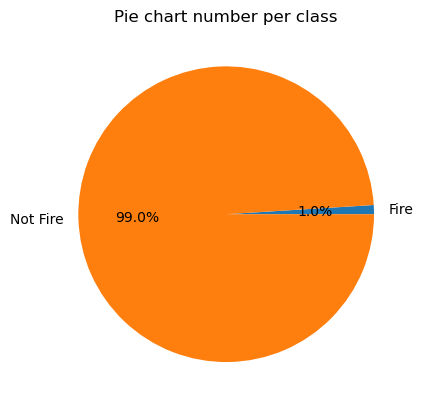

In [10]:
# Pie chart number per class
plt.pie(df_1['nClasses'], labels=df_1['Classes'], autopct='%1.1f%%')
plt.title("Pie chart number per class")
plt.show()

/tmp/ipykernel_91682/1508061544.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y=df[column].fillna(method='ffill'),
/tmp/ipykernel_91682/1508061544.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y=df[column].fillna(method='ffill'),
/tmp/ipykernel_91682/1508061544.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y=df[column].fillna(method='ffill'),
/tmp/ipykernel_91682/1508061544.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y=df[column].fillna(method='ffill'),
/tmp/ipykernel_91682/1508061544.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill(

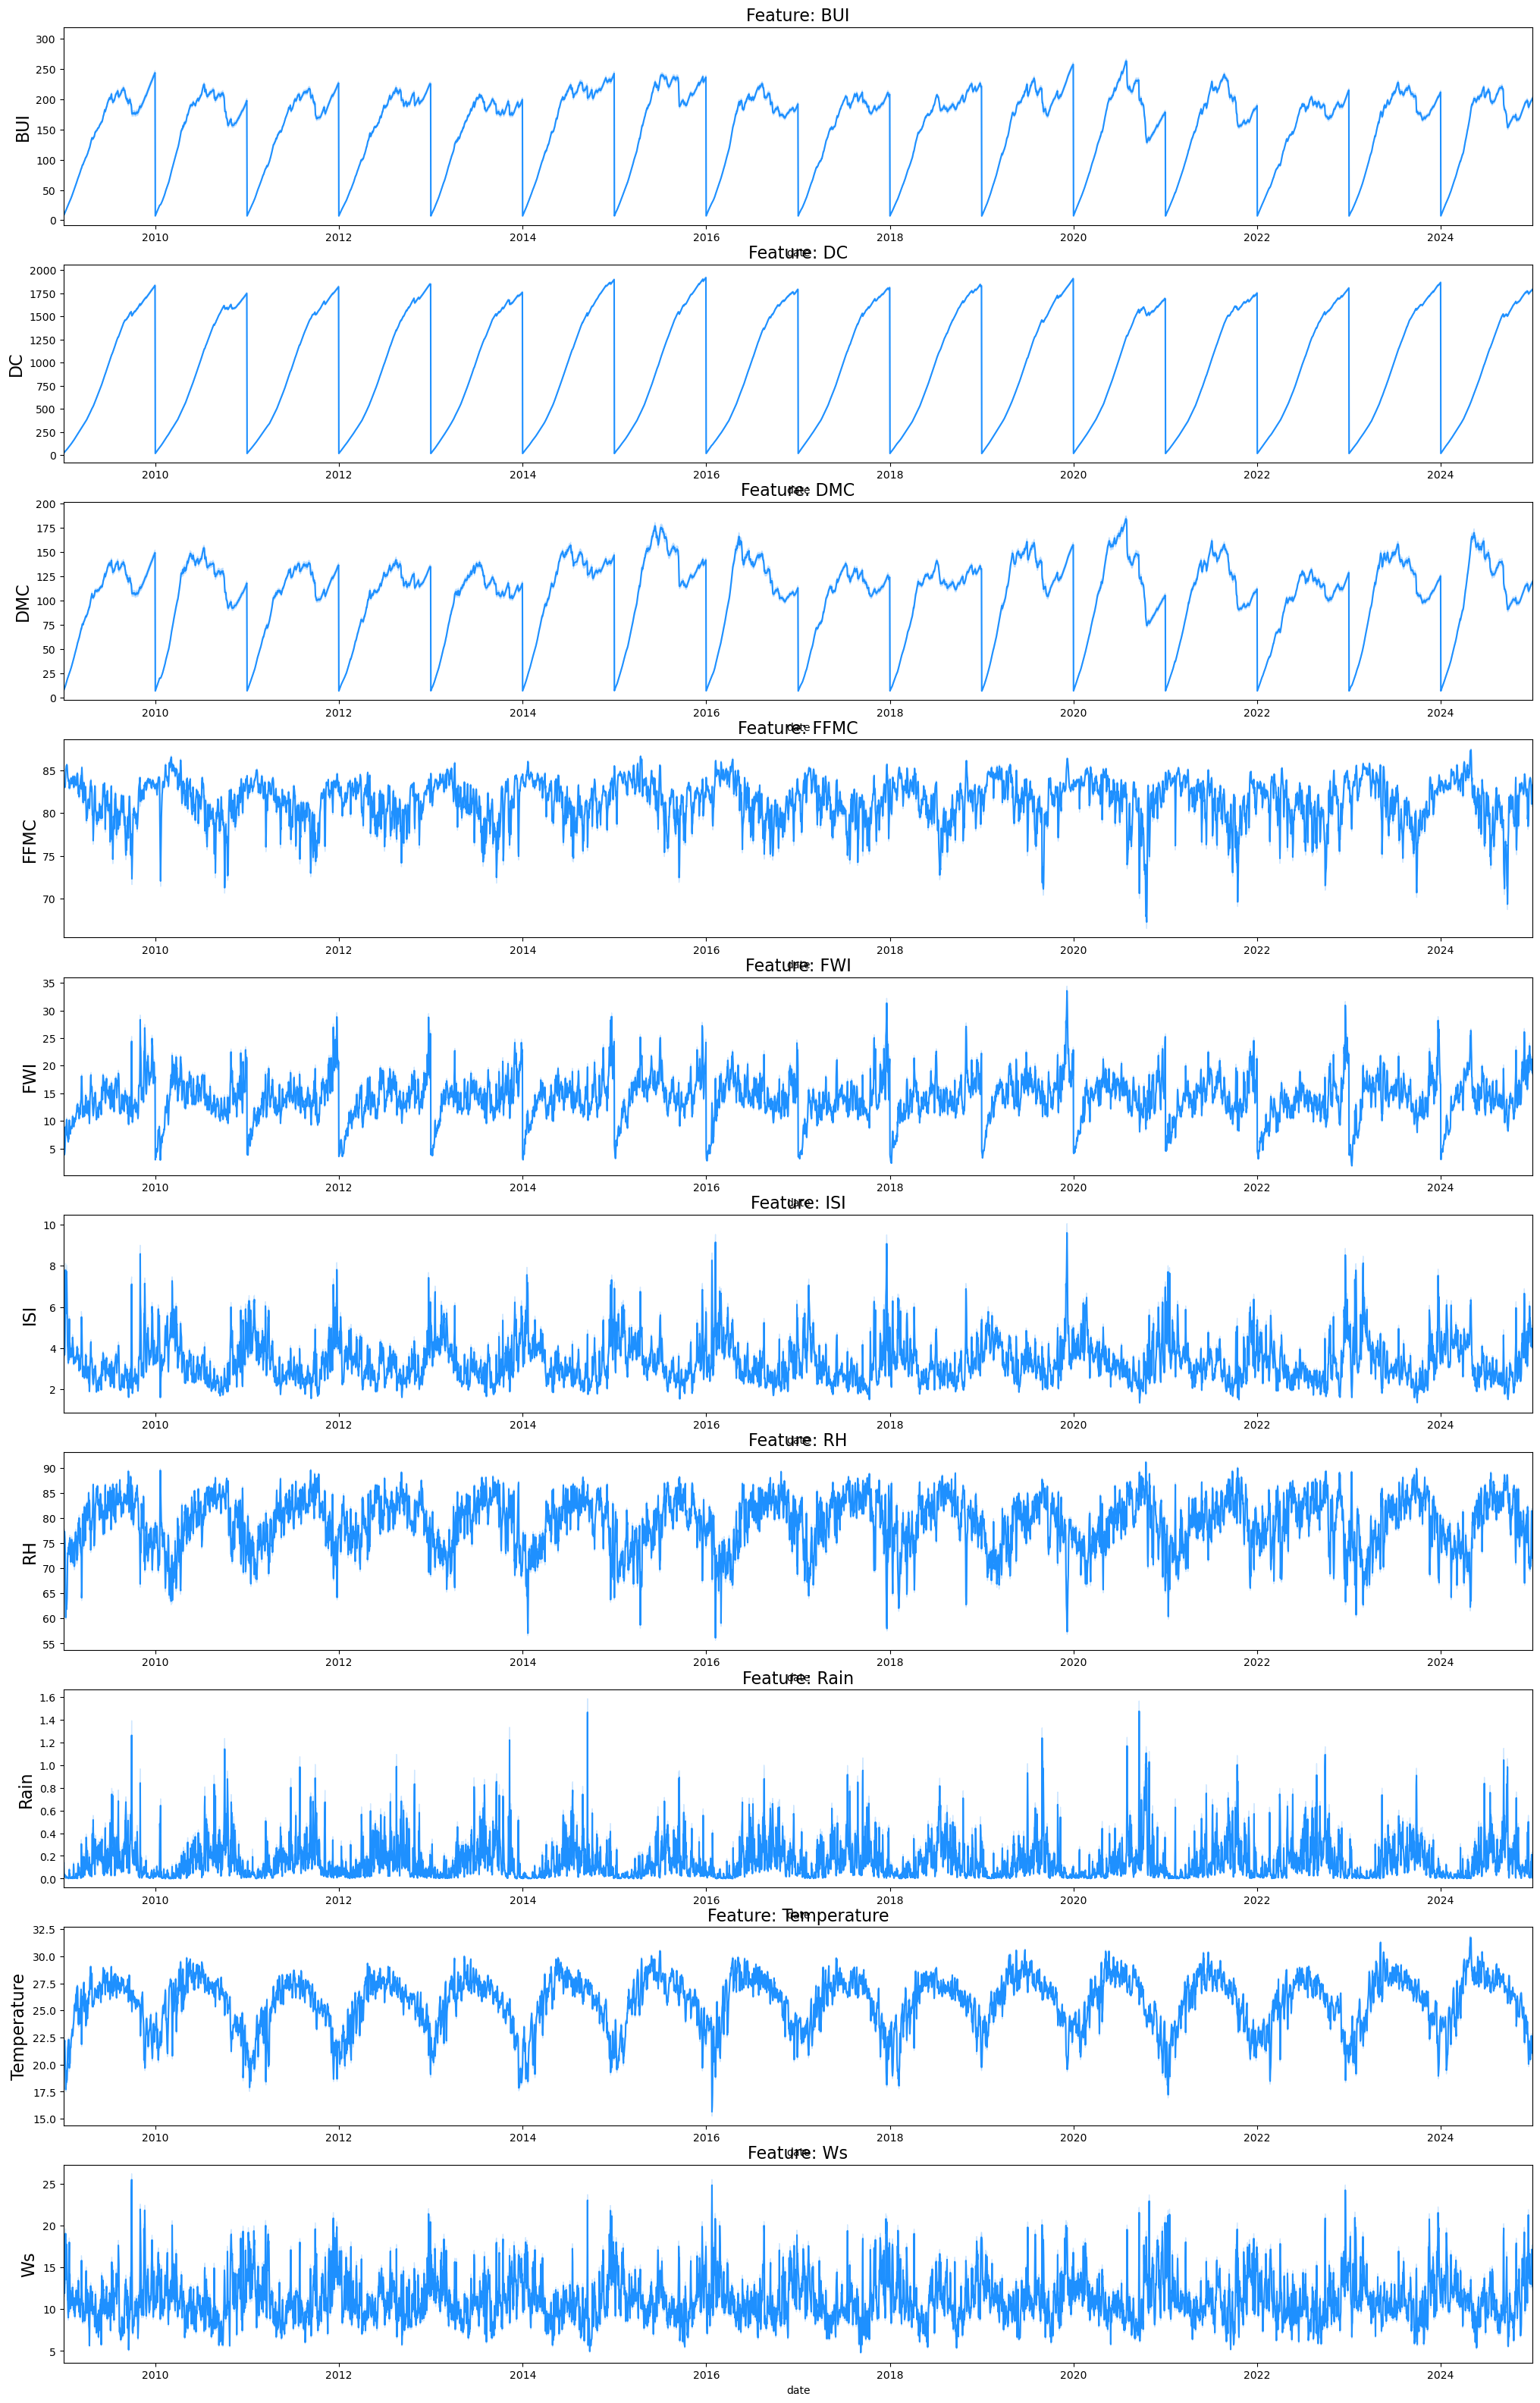

In [15]:
cols = df.columns.difference(['date', 'lat_grid', 'lon_grid', 'Classes'])

f, ax = plt.subplots(nrows=10, ncols=1, figsize=(25, 40))
for i, column in enumerate(cols):
    sns.lineplot(
        x=df['date'], 
        y=df[column].fillna(method='ffill'), 
        ax=ax[i], 
        color='dodgerblue'
        )
    ax[i].set_title('Feature: {}'.format(column), fontsize=16)
    ax[i].set_ylabel(ylabel=column, fontsize=16)
    ax[i].set_xlim([date(2009, 1, 1), date(2024, 12, 31)])

# 2. Data Preprocessing

### 2.1 Handle Missing Values

In [16]:
df.isna().sum()

date           0
lat_grid       0
lon_grid       0
Temperature    0
RH             0
Ws             0
Rain           0
FFMC           0
DMC            0
DC             0
ISI            0
BUI            0
FWI            0
Classes        0
dtype: int64

### 2.2 Balance Data Using Downsampling For Class Not Fire

In [35]:
fire_df = df[df["Classes"]=='fire']
notfire_df = df[df["Classes"]=='not fire']
n_fire = len(fire_df)
n_not_target = min(len(notfire_df), n_fire + max(0,int(100)))
notfire_keep = notfire_df.sample(n=n_not_target, random_state=42, replace=False)

In [72]:
# Merge fire and not fire class
balance_df = pd.concat([fire_df, notfire_keep], axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)
balance_df['date'] = pd.to_datetime(balance_df['date'])
balance_df = balance_df.sort_values(by='date')
balance_df.reset_index(drop=True, inplace=True)

In [45]:
balance_df

,date,lat_grid,lon_grid,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,2000-01-01,11.50,107.75,22.01650,92.782867,5.544386,0.000477,80.034759,6.205390,18.666970,1.509172,6.777901,0.746127,not fire
1,2000-01-01,13.75,109.25,23.06730,83.845829,24.177628,0.040531,82.937001,6.480625,18.856114,5.416351,6.971335,4.872308,not fire
2,2000-01-01,11.50,109.50,23.92666,89.536068,39.646609,0.157833,81.080131,6.322397,19.010799,9.432270,6.904359,8.194074,not fire
3,2000-01-01,19.00,104.50,16.16300,96.903342,4.729598,0.000477,77.941433,6.065812,17.613340,1.189764,6.518984,0.577349,not fire
4,2000-01-01,20.00,106.25,18.83486,89.855327,12.890250,0.000000,80.767509,6.248969,18.094275,2.364850,6.707096,1.595132,not fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364241,2024-12-31,20.25,104.25,13.85903,90.727925,4.104825,0.005722,77.829233,177.031260,1864.260811,1.142241,286.133923,7.942312,not fire
364242,2024-12-31,8.75,105.50,27.86685,74.605180,2.396473,0.000000,83.596397,72.907507,1587.279341,1.968432,130.795629,10.757721,not fire
364243,2024-12-31,21.50,107.25,14.82388,73.455268,3.937549,0.000000,82.452129,132.934725,1637.317742,1.837566,221.009702,11.661525,fire
364244,2024-12-31,22.75,107.75,13.05630,73.139120,6.416919,0.000000,83.776097,138.298529,1684.602903,2.468244,229.495597,14.764431,not fire


In [47]:
not_fire = balance_df[balance_df['Classes'] == 'not fire'].shape[0]
fire = balance_df[balance_df['Classes'] == 'fire'].shape[0]

print(f'Number of Fire classes: {fire:,}\nNumber of Not Fire classes: {not_fire:,}')

Number of Fire classes: 182,073
Number of Not Fire classes: 182,173


In [49]:
dic = {
    'nClasses': [fire, not_fire],
    'Classes': ['Fire','Not Fire']
}

df_2 = pd.DataFrame(dic)

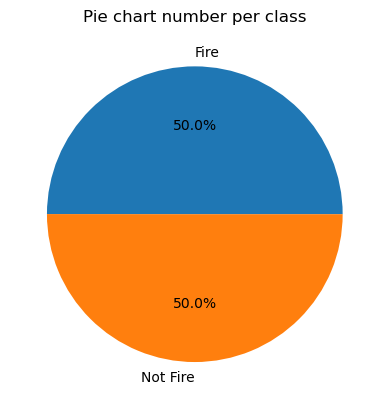

In [50]:
# Pie chart number per class
plt.pie(df_2['nClasses'], labels=df_2['Classes'], autopct='%1.1f%%')
plt.title("Pie chart number per class")
plt.show()

array([[<Axes: title={'center': 'date'}>,
        <Axes: title={'center': 'lat_grid'}>,
        <Axes: title={'center': 'lon_grid'}>,
        <Axes: title={'center': 'Temperature'}>],
       [<Axes: title={'center': 'RH'}>, <Axes: title={'center': 'Ws'}>,
        <Axes: title={'center': 'Rain'}>,
        <Axes: title={'center': 'FFMC'}>],
       [<Axes: title={'center': 'DMC'}>, <Axes: title={'center': 'DC'}>,
        <Axes: title={'center': 'ISI'}>, <Axes: title={'center': 'BUI'}>],
       [<Axes: title={'center': 'FWI'}>,
        <Axes: title={'center': 'Classes'}>, <Axes: >, <Axes: >]],
      dtype=object)

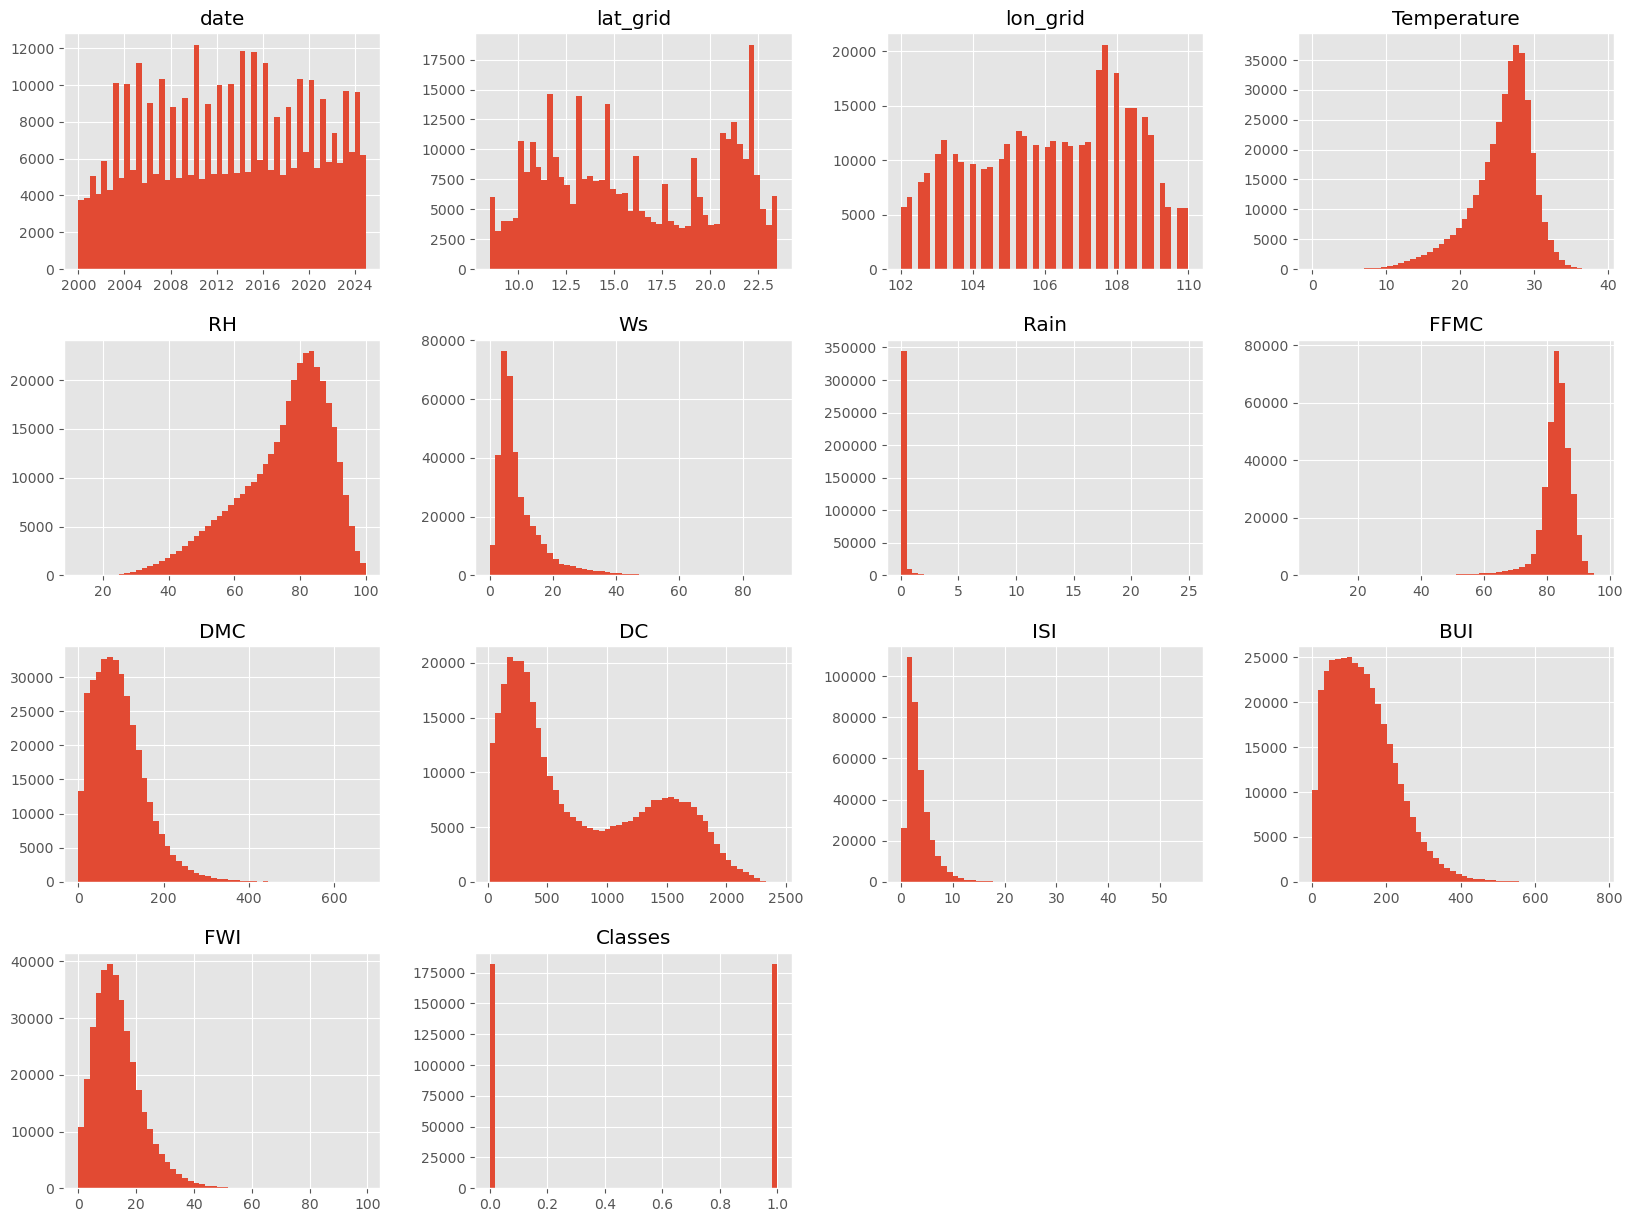

In [ ]:
# Desnsity plot for all the features
plt.style.use('ggplot')
balance_df.hist(bins=50, figsize=(20, 15))

<Axes: xlabel='date', ylabel='count'>

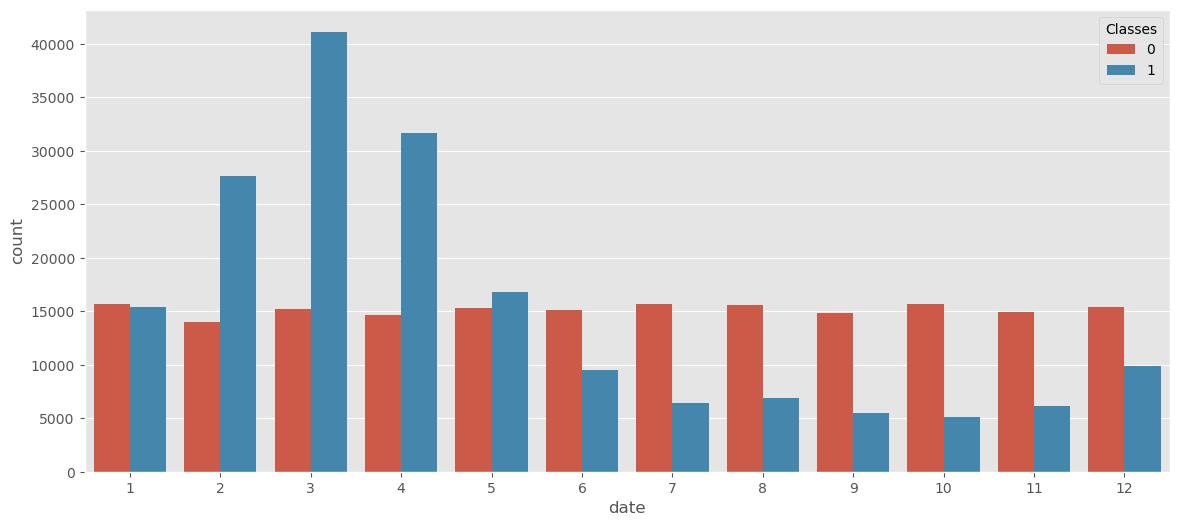

In [67]:
# monthy fire analysis
plt.figure(figsize=(14, 6))
sns.countplot(x=balance_df['date'].dt.month, hue=balance_df['Classes'])

## 3. Feature Engineering

In [75]:
balance_df["Classes"] = balance_df["Classes"].map(lambda x: 1 if str(x).strip().lower()=="fire" else 0)

In [54]:
balance_df

,date,lat_grid,lon_grid,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,2000-01-01,11.50,107.75,22.01650,92.782867,5.544386,0.000477,80.034759,6.205390,18.666970,1.509172,6.777901,0.746127,0
1,2000-01-01,13.75,109.25,23.06730,83.845829,24.177628,0.040531,82.937001,6.480625,18.856114,5.416351,6.971335,4.872308,0
2,2000-01-01,11.50,109.50,23.92666,89.536068,39.646609,0.157833,81.080131,6.322397,19.010799,9.432270,6.904359,8.194074,0
3,2000-01-01,19.00,104.50,16.16300,96.903342,4.729598,0.000477,77.941433,6.065812,17.613340,1.189764,6.518984,0.577349,0
4,2000-01-01,20.00,106.25,18.83486,89.855327,12.890250,0.000000,80.767509,6.248969,18.094275,2.364850,6.707096,1.595132,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364241,2024-12-31,20.25,104.25,13.85903,90.727925,4.104825,0.005722,77.829233,177.031260,1864.260811,1.142241,286.133923,7.942312,0
364242,2024-12-31,8.75,105.50,27.86685,74.605180,2.396473,0.000000,83.596397,72.907507,1587.279341,1.968432,130.795629,10.757721,0
364243,2024-12-31,21.50,107.25,14.82388,73.455268,3.937549,0.000000,82.452129,132.934725,1637.317742,1.837566,221.009702,11.661525,1
364244,2024-12-31,22.75,107.75,13.05630,73.139120,6.416919,0.000000,83.776097,138.298529,1684.602903,2.468244,229.495597,14.764431,0


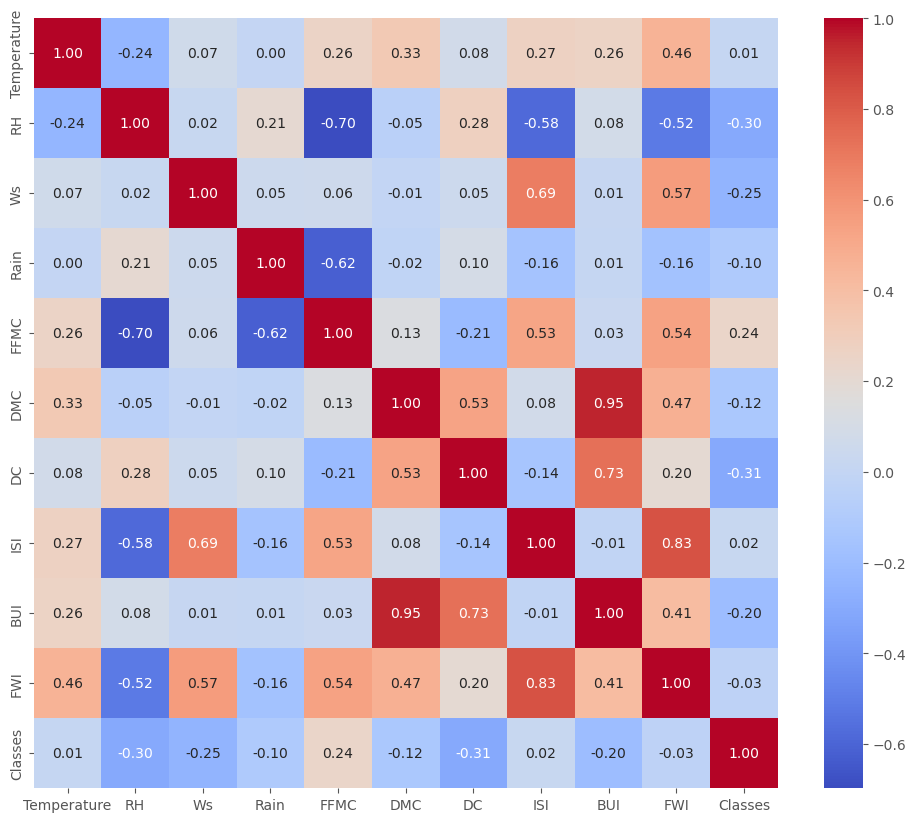

In [59]:
# correlation plot for all the features
numeric_cols = ['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes']
corr = balance_df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

## 4. Model Training

In [73]:
balance_df.drop(['date', 'lat_grid', 'lon_grid'], axis=1, inplace=True)

In [76]:
balance_df

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,22.01650,92.782867,5.544386,0.000477,80.034759,6.205390,18.666970,1.509172,6.777901,0.746127,0
1,23.06730,83.845829,24.177628,0.040531,82.937001,6.480625,18.856114,5.416351,6.971335,4.872308,0
2,23.92666,89.536068,39.646609,0.157833,81.080131,6.322397,19.010799,9.432270,6.904359,8.194074,0
3,16.16300,96.903342,4.729598,0.000477,77.941433,6.065812,17.613340,1.189764,6.518984,0.577349,0
4,18.83486,89.855327,12.890250,0.000000,80.767509,6.248969,18.094275,2.364850,6.707096,1.595132,0
...,...,...,...,...,...,...,...,...,...,...,...
364241,13.85903,90.727925,4.104825,0.005722,77.829233,177.031260,1864.260811,1.142241,286.133923,7.942312,0
364242,27.86685,74.605180,2.396473,0.000000,83.596397,72.907507,1587.279341,1.968432,130.795629,10.757721,0
364243,14.82388,73.455268,3.937549,0.000000,82.452129,132.934725,1637.317742,1.837566,221.009702,11.661525,1
364244,13.05630,73.139120,6.416919,0.000000,83.776097,138.298529,1684.602903,2.468244,229.495597,14.764431,0


In [77]:
balance_df.Classes.value_counts()

Classes
0    182173
1    182073
Name: count, dtype: int64

### 4.1 Train/Test Split and Feature Scaling Setup

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

feature_cols = [col for col in balance_df.columns if col != 'Classes']
X = balance_df[feature_cols].values
y = balance_df['Classes'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((291396, 10), (72850, 10))

### 4.2 Classical Models with StandardScaler and MinMaxScaler

In [84]:
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler()
}

In [85]:
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    ),
    'XGBoost': XGBClassifier(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False
    )
}


In [86]:

classic_results = []

for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, preds)
        report = classification_report(
            y_test, preds, output_dict=True, zero_division=0
        )
        classic_results.append({
            'scaler': scaler_name,
            'model': model_name,
            'accuracy': acc,
            'fire_precision': report['1']['precision'],
            'fire_recall': report['1']['recall']
        })
        print(f"{model_name} + {scaler_name} | Accuracy: {acc:.4f} | Fire Recall: {report['1']['recall']:.4f}")

RandomForest + StandardScaler | Accuracy: 0.7687 | Fire Recall: 0.7675
XGBoost + StandardScaler | Accuracy: 0.7606 | Fire Recall: 0.7606
RandomForest + MinMaxScaler | Accuracy: 0.7685 | Fire Recall: 0.7683
XGBoost + MinMaxScaler | Accuracy: 0.7602 | Fire Recall: 0.7604


In [87]:
classic_results_df = pd.DataFrame(classic_results)
classic_results_df.sort_values(by='accuracy', ascending=False)

,scaler,model,accuracy,fire_precision,fire_recall
0,StandardScaler,RandomForest,0.768662,0.769167,0.767541
2,MinMaxScaler,RandomForest,0.768538,0.768593,0.768255
1,StandardScaler,XGBoost,0.760563,0.760418,0.760648
3,MinMaxScaler,XGBoost,0.760233,0.760032,0.760428


Random Forest and Standard Scaler have the best performence

#### Performance Visualization

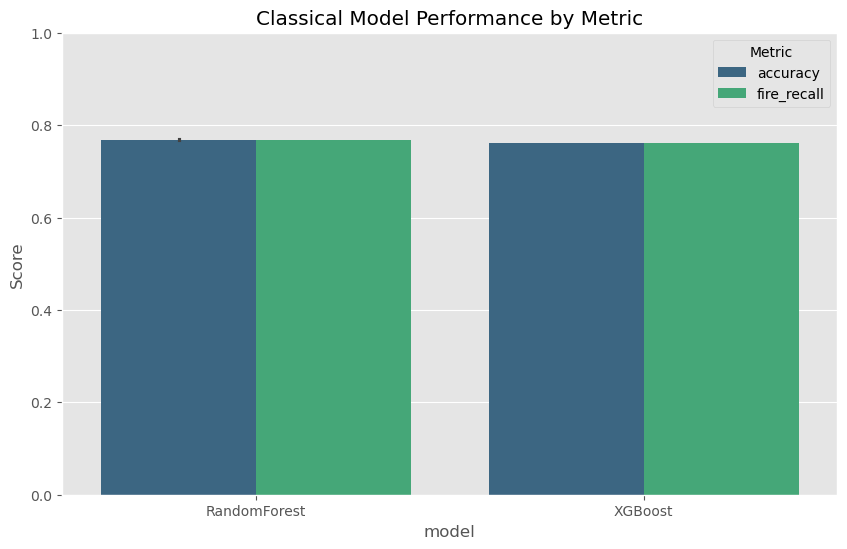

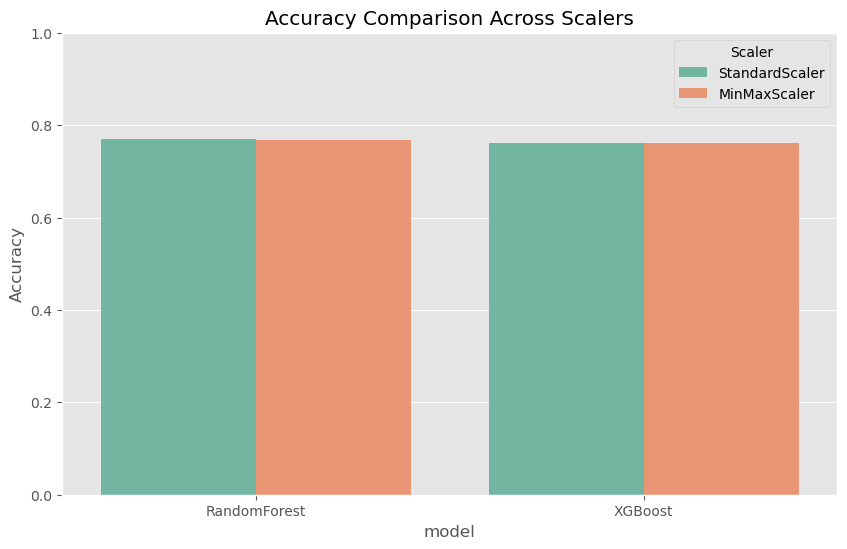

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_df = classic_results_df.melt(
    id_vars=['model', 'scaler'],
    value_vars=['accuracy', 'fire_recall'],
    var_name='metric',
    value_name='score'
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=plot_df,
    x='model', y='score', hue='metric',
    palette='viridis'
)
plt.title('Classical Model Performance by Metric')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.legend(title='Metric')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=classic_results_df,
    x='model', y='accuracy', hue='scaler',
    palette='Set2'
)
plt.title('Accuracy Comparison Across Scalers')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.legend(title='Scaler')
plt.show()
